# Calculate CMIP Indeces

This file 
1. calculates all the 'traditional' indeces defined in utils/_indexDefinitions for all months for all models.
2. it then averages the result over the warm season
3. and figures out what years there are compounding events



In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound


In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
modelSet=_model.scenarioMip

In [5]:
experimentSet=['piControl','ssp585']

# 1. Calculate CMIP Indeces

For each experiment and model, calculate indices

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [6]:
varsToDetrend=[
    'dmi',
    'eastIO',
    #'nino3',
    'nino34',
    'westIO',
    'nino4',
    #'samWinter',
    #'samSummer'
]

In [9]:
for experiment in experimentSet:
    timePIndeces=list()

    for model in _model.scenarioMip[:,1]:
        #try:
            indecesDs = xarray.open_dataset('results/cmipMonthlyIndeces/' + model +'tos'+ experiment + '.nc')
            indecesDs['model']=model
            indecesDs=indecesDs.set_coords({'model':model})
            
            seasonAv=tp.averageForTimePeriod(indecesDs)
            seasonAv['dmiNoDetrend']=seasonAv.dmi
            
            for iVar in varsToDetrend:
                seasonAv[iVar+'RollingDetrend']=(
                    seasonAv[iVar+'NoDetrend']
                    -seasonAv[iVar+'NoDetrend'].rolling(
                        year=11,min_periods=5,center=True
                    ).mean('year')
                )
                
            timePIndeces.append(
                seasonAv
            )
        #except Exception as e:
        #    print('skipping' + model + experiment) 
            
    results=xarray.concat(timePIndeces, 'model')
    results.to_netcdf('results/cmip6'+experiment+'TradIndecesTos.nc')


In [10]:
results

<xarray.Dataset>
Dimensions:                 (year: 450, model: 35)
Coordinates:
  * year                    (year) int64 1850 1851 1852 1853 ... 2297 2298 2299
  * model                   (model) <U16 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/19)
    nino34NoDetrend         (model, year) float64 -0.377 0.7301 ... nan nan
    nino34                  (model, year) float64 -0.1529 0.6709 ... nan nan
    westIO                  (model, year) float64 0.08339 0.1271 ... nan nan
    nino4NoDetrend          (model, year) float64 -0.1826 0.4717 ... nan nan
    eastIONoDetrend         (model, year) float64 -0.7739 0.1518 ... nan nan
    westIONoDetrend         (model, year) float64 -0.1756 0.1422 ... nan nan
    ...                      ...
    dmiNoDetrend            (model, year) float64 0.5983 -0.009583 ... nan nan
    dmiRollingDetrend       (model, year) float64 0.1778 -0.3087 ... nan nan
    eastIORollingDetrend    (model, year) float64 -0.4793 0.3339 ... nan nan
    nino34RollingDetrend    (model, year) float64 -0.6412 0.5291 ... nan nan
    westIORollingDetrend    (model, year) float64 -0.3015 0.02516 ... nan nan
    nino4RollingDetrend     (model, year) float64 -0.4306 0.2568 ... nan nan

# Some sanity checks to see if it looks ok:


In [7]:
results=xarray.open_dataset('results/cmip6ssp585TradIndecesTos.nc').sel(year=slice(1850,2099))


In [13]:
str(results.isel(model=6).model.values)

'CESM2'

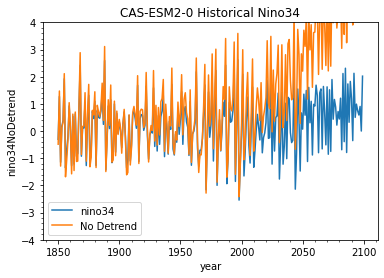

In [14]:
# plotSomething
results.isel(model=6).nino34.plot(label='nino34')
results.isel(model=6).nino34NoDetrend.plot(label='No Detrend')

#Tidy up a bit
plt.title(str(results.isel(model=5).model.values) + " Historical Nino34")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

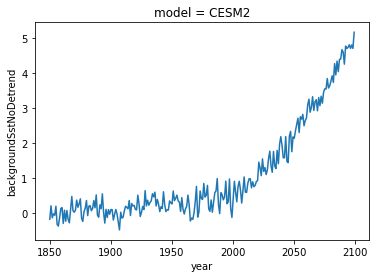

In [15]:
results.backgroundSstNoDetrend.isel(model=6).plot()

In [8]:
piControlXr=xarray.open_dataset('results/cmip6piControlTradIndecesTos.nc')

In [17]:
# This should calculate stds for all experiments and all indeces
stdXr = piControlXr.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaXr= xarray.merge(
    (stdXr[['nino34','dmi']], stdXr['samSummer']/2)
)

# Plot time trends

For comparison, also load the observational results

In [10]:
obsXr=xarray.open_dataset('results/obsIndeces.nc')

In [11]:
obsXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
    mode                    int64 ...
Data variables: (12/21)
    nino3                   (year) float64 ...
    westIONoDetrend         (year) float64 ...
    dmi                     (year) float64 ...
    westIO                  (year) float64 ...
    eastIONoDetrend         (year) float64 ...
    nino4                   (year) float64 ...
    ...                      ...
    westIORollingDetrend    (year) float64 ...
    nino4RollingDetrend     (year) float64 ...
    cIndex                  (year) float64 ...
    eIndex                  (year) float64 ...
    samSummer               (year) float64 ...
    samWinter               (year) float64 ...

In [33]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'samWinter', 'samSummer']
labels = ['Niño3.4', 'DMI', 'SamCoolSeason', 'SamWarmSeason']
ylabels = ['Index(°C)','Index(°C)','Index','Index']
colors = ['peru', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4], [-4,4]]

Multi model mean

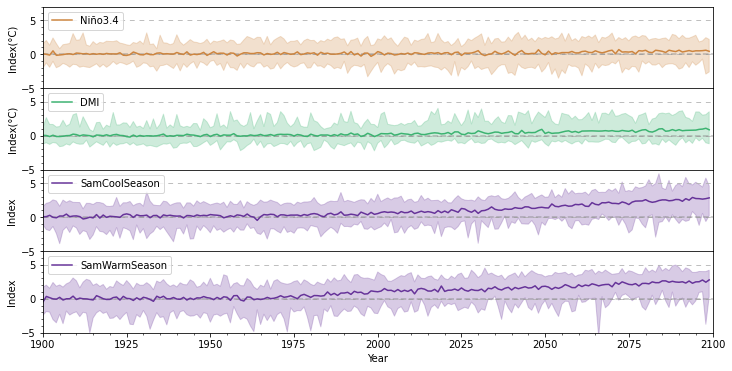

In [34]:
axs=list()
fig = plt.figure(figsize=(12,6))

for i in range(4):

    #create a subplot (row, column, size)
    axs.append(fig.add_subplot(4,1,i+1))

    # plot the actual data
    plotData=results[indexToPlot[i]]

    #blue line for multi-experiment mean, and light blue shading between min and max
    plt.plot(
        plotData.year, 
        plotData.mean('model').values, 
        label=labels[i], 
        color=colors[i]
    )
    plt.legend(loc='upper left')
    
    #obsXr[indexToPlot[i]].plot(alpha=0.5, linestyle='-')
    
    plt.fill_between(
        plotData.year, plotData.min('model').values, plotData.max('model').values, 
                     color=colors[i], alpha=0.25
    )
    
    plt.xlim([1900,2100])
    plt.ylim([-5,7])
    plt.minorticks_on()
    plt.ylabel(ylabels[i])
    plt.xlabel('')
    plt.hlines(0,1900,2100, color='grey', linestyles='dashed', alpha=0.5)
    axs[i].xaxis.set_visible(False)
    plt.grid(axis='y', dashes=(6,6))

    
plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
axs[-1].xaxis.set_visible(True)

plt.savefig('figures/cmip6IndexTrends.pdf',bbox_inches='tight')

Rolling Variability

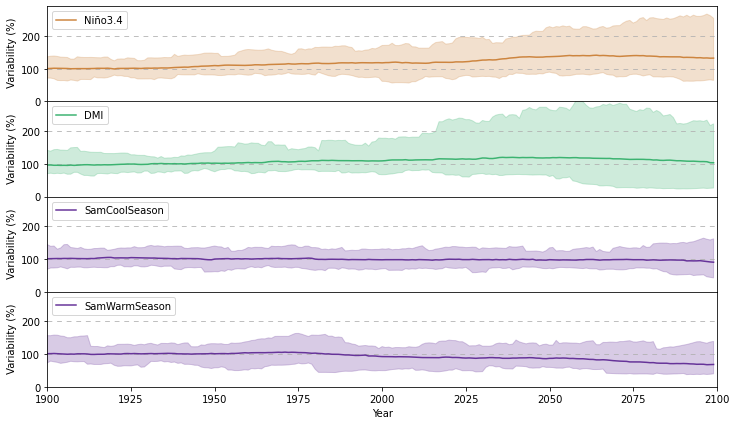

In [36]:
fig = plt.figure(figsize=(12,7))

for i in range(4):
    #create a subplot (row, column, size)
    ax=fig.add_subplot(4,1,i+1)

    # rolling sigma, as a percentage of mean from pi control
    plotData=(
        (
            results[indexToPlot[i]].rolling(
                year=30, min_periods=15, center=True
            ).std('year')
        )
        /(
            piControlXr[indexToPlot[i]].rolling(
                year=30, min_periods=15, center=True
            ).std('year').mean('year')
        )
        *100
    )

    #solid line for multi-experiment mean
    plt.plot(
        plotData.year, 
        plotData.mean('model'), 
        label=labels[i], 
        color=colors[i]
    )
    plt.legend(loc='upper left')
    
    '''(
        obsXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year')
        /obsXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').sel(year=slice(1971,2000)).mean()
        *100
    ).plot()'''
    
    #shading between min and max
    plt.fill_between(
        plotData.year, 
        plotData.min('model'),
        plotData.max('model'), 
        color=colors[i],
        alpha=0.25
    )
    
    #tidy up
    plt.ylim([0,290])
    plt.xlim([1900,2100])
    plt.ylabel('Variability (%)')
    plt.xlabel('')
    plt.title('')
    ax.xaxis.set_visible(False)
    plt.grid(axis='y', dashes=(6,6))

plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
ax.xaxis.set_visible(True)

plt.savefig(
    'figures/cmip6IndexStdTrends.pdf',
    bbox_inches='tight'
)

# ENSO Contamination with Global Warming signal

In [29]:
results

<xarray.Dataset>
Dimensions:                 (year: 250, model: 35)
Coordinates:
  * year                    (year) int64 1850 1851 1852 1853 ... 2097 2098 2099
  * model                   (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/19)
    nino34NoDetrend         (model, year) float64 ...
    nino34                  (model, year) float64 -0.1529 0.6709 ... 0.2094
    westIO                  (model, year) float64 ...
    nino4NoDetrend          (model, year) float64 ...
    eastIONoDetrend         (model, year) float64 ...
    westIONoDetrend         (model, year) float64 ...
    ...                      ...
    dmiNoDetrend            (model, year) float64 ...
    dmiRollingDetrend       (model, year) float64 ...
    eastIORollingDetrend    (model, year) float64 ...
    nino34RollingDetrend    (model, year) float64 ...
    westIORollingDetrend    (model, year) float64 ...
    nino4RollingDetrend     (model, year) float64 ...

In [30]:
%run utils/emergence.ipynb

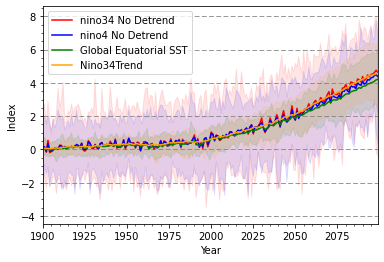

In [31]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        results[['nino34NoDetrend','nino4NoDetrend','backgroundSstNoDetrend']],
        results['nino34NoDetrend'].rolling(year=11,center=True,min_periods=5).mean('year').rename('nino34Trend')
    ])
)

plt.ylabel('Index')
#plt.ylim([-2,2])
plt.xlim([1900,2099])
plt.grid(axis='y', color='grey', dashes=[6,3])
plt.legend(['nino34 No Detrend', 'nino4 No Detrend', 'Global Equatorial SST', 'Nino34Trend'])
#plt.savefig('results/dmiVsEastIO.png')

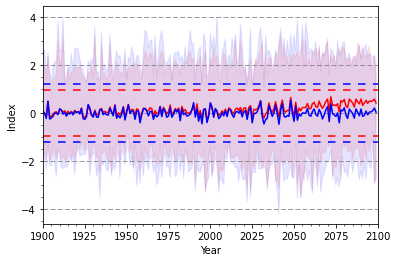

In [32]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        results['nino34'],
        (
            results['nino34NoDetrend']
            -results['nino34NoDetrend'].rolling(year=11,center=True,min_periods=5).mean('year')
        ).rename('nino34 Rolling Detrend')
    ]),
    xarray.merge([
        piControlXr['nino34'],
        (
            piControlXr['nino34NoDetrend']
            -piControlXr['nino34NoDetrend'].rolling(year=11,center=True,min_periods=5).mean('year')
        ).rename('nino34 Rolling Detrend')
    ])
)

plt.ylabel('Index')
#plt.ylim([-2,2])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])
#plt.legend(['nino34', 'nino34 Rolling DeTrend'])
#plt.savefig('results/dmiVsEastIO.png')

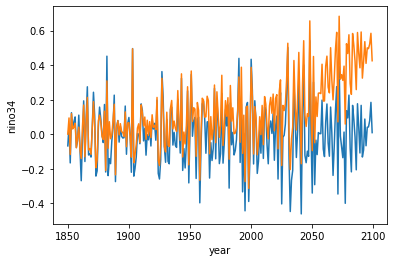

In [33]:
results.nino34RollingDetrend.mean('model').plot()
results.nino34.mean('model').plot()

# ENSO Trends

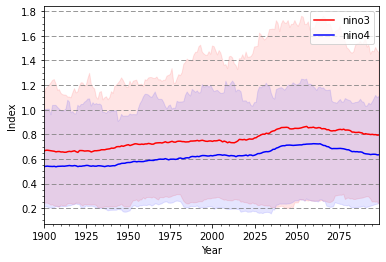

In [34]:
overlaidEmergePlot(
        results[['nino3','nino4']].rolling(year=30,min_periods=15,center=True).std('year')
)

plt.ylabel('Index')
#plt.ylim([-2,2])
plt.xlim([1900,2099])
plt.grid(axis='y', color='grey', dashes=[6,3])
plt.legend(['nino3', 'nino4',])
#plt.savefig('results/dmiVsEastIO.png')

# IOD Western vs Eastern

In [35]:
%run utils/emergence.ipynb

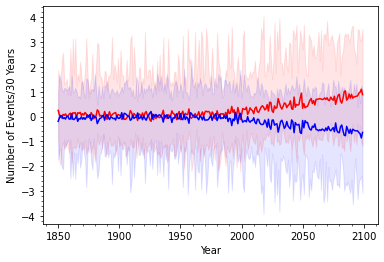

In [36]:
overlaidEmergePlot(
    results[['dmi','eastIO']]
)

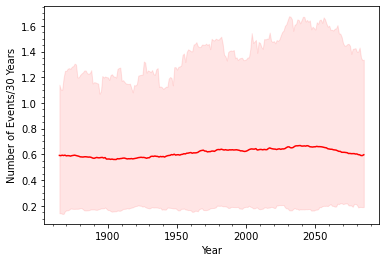

In [37]:
overlaidEmergePlot(
    results.sel(year=slice(1850,2099)).dmiNoDetrend.rolling(year=30,center=True).std('year').to_dataset()
)

In [38]:
for experiment in experimentSet:
    timePIndeces=list()

    for model in _model.scenarioMip[:,1]:
        try:
            indecesDs = xarray.open_dataset('results/cmipMonthlyIndeces/' + model +'tos'+ experiment + '.nc')
            indecesDs['model']=model
            timePIndeces.append(
                tp.averageForTimePeriod(
                    indecesDs[[
                        'dmi',
                        'eastIONoDetrend',
                        'westIONoDetrend', 
                        'backgroundSstNoDetrend', 
                        'westIO', 
                        'eastIO'
                    ]]
                ).sel(year=slice(1850,2099))
            )
        except Exception as e:
            print('skipping' + model + experiment) 
            
ioXr=xarray.concat(timePIndeces, 'model')




In [39]:
ioXr

<xarray.Dataset>
Dimensions:                 (year: 250, model: 35)
Coordinates:
  * year                    (year) int64 1850 1851 1852 1853 ... 2097 2098 2099
Dimensions without coordinates: model
Data variables:
    eastIONoDetrend         (model, year) float64 -0.7739 0.1518 ... 3.42 4.391
    westIONoDetrend         (model, year) float64 -0.1756 0.1422 ... 5.202 5.403
    dmi                     (model, year) float64 0.5983 -0.009583 ... 1.012
    eastIO                  (model, year) float64 -0.5149 0.1367 ... -0.7447
    backgroundSstNoDetrend  (model, year) float64 -0.224 0.05919 ... 5.232 5.205
    westIO                  (model, year) float64 0.08339 0.1271 ... 0.2672

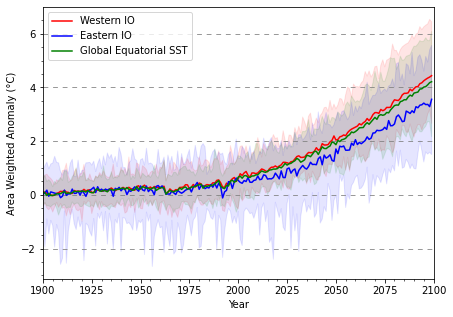

In [57]:
plt.figure(figsize=(7,5))
overlaidEmergePlot(
    ioXr[['westIONoDetrend','eastIONoDetrend','backgroundSstNoDetrend']]
    #ioXr
)

plt.ylabel('Area Weighted Anomaly (°C)')
plt.xlim([1900,2100])
plt.legend(['Western IO', 'Eastern IO','Global Equatorial SST'], loc='upper left')
plt.grid(axis='y', color='grey', dashes=[6,6])

plt.savefig('figures/cmip6WestVsEastIO.pdf',bbox_inches='tight')

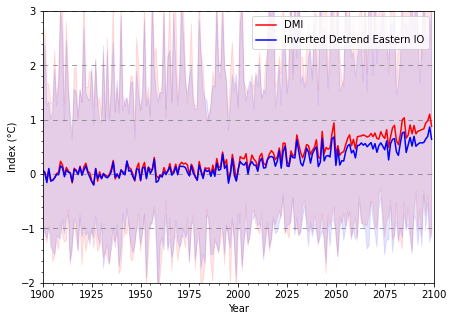

In [56]:
plt.figure(figsize=(7,5))
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        ioXr.dmi,
        ioXr.eastIO*-1
    ]),
    #to make a baseline, use piContorl
    #xarray.merge([
    #    piControlXr.dmi,
    #    piControlXr.eastIO*-1
    #])
)

plt.ylabel('Index (°C)')
plt.ylim([-2,3])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,6])
plt.legend(['DMI','Inverted Detrend Eastern IO'])
plt.savefig('figures/cmip6DmiTrend.pdf',bbox_inches='tight')

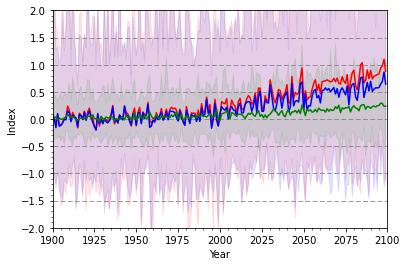

In [42]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        ioXr.dmi,
        ioXr.eastIO*-1,
        ioXr.westIO
    ]),
    #to make a baseline, use piContorl
    #xarray.merge([
    #    piControlXr.dmi,
    #    piControlXr.eastIO*-1
    #])
)

plt.ylabel('Index')
plt.ylim([-2,2])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])
#plt.legend(['DMI', 'Inverted Detrend Eastern IO'])


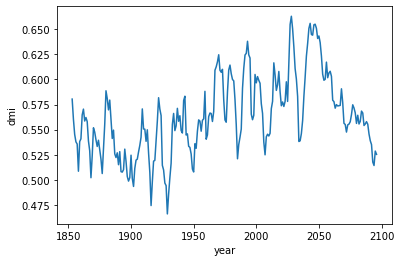

In [43]:
ioXr.dmi.rolling(year=7,center=True).std('year').mean('model').plot()

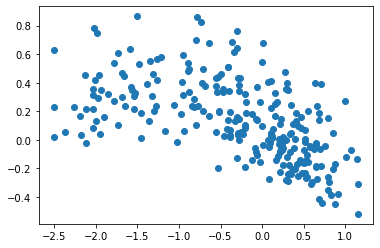

In [44]:
plt.scatter(ioXr.isel(model=5).eastIO,ioXr.isel(model=5).westIO)

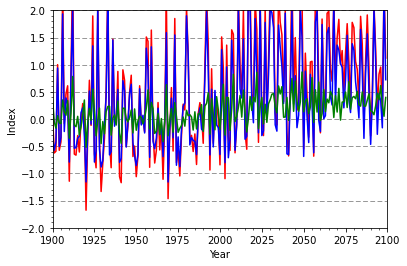

In [45]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        ioXr.dmi,
        ioXr.eastIO*-1,
        ioXr.westIO
    ]).isel(model=5),
    #to make a baseline, use piContorl
    #xarray.merge([
    #    piControlXr.dmi,
    #    piControlXr.eastIO*-1
    #])
)

plt.ylabel('Index')
plt.ylim([-2,2])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])
#plt.legend(['DMI', 'Inverted Detrend Eastern IO'])
